# Analysis and plots.



In [116]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = 15, 9
#plt.rcParams['font.size'] = 19
#plt.rcParams['axes.titlesize'] = 24
import matplotlib as mpl
inline_rc = dict(mpl.rcParams)
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(inline_rc)
plt.rcParams['figure.figsize'] = 15, 9
plt.rcParams['font.size'] = 19
plt.rcParams['axes.titlesize'] = 24

In [110]:
# Needs MafSSO branch from sims_maf.
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as mmb

In [3]:
# Read PHA and NEO observations (MBAs coming)
runName = 'enigma_1189'
# Go through all types of objects, with 2k results. 
moslicers = {}
objtypes = ['phas', 'neos', 'mbas', 'trojans', 'tnos', 'sdos', 'comets']
Hrange = np.arange(5, 27, 0.25)
for obj in objtypes:
    orbitfile = os.path.join('ssm_2k', obj+'.des')
    moslicers[obj] = slicers.MoSlicer(orbitfile, Hrange=Hrange)
    obsfile = os.path.join('ssm_2k', obj+'_allObs.txt' )
    moslicers[obj].readObs(obsfile)

In [4]:
# Set up metrics and metric bundles.
allBundles = {}
nyears = [2, 4, 6, 8, 10]
psfFactor = 2.0
windows = np.arange(1, 40, 3)*5
bins = np.arange(5, 95, 10.)
summaryMetrics = [metrics.MO_CompletenessMetric(), metrics.MO_CumulativeCompletenessMetric()]
for obj in objtypes:
    bundles = {}
    slicer = moslicers[obj]
    plotDict = {}
    constraint = None
    metadata = obj
    
    
    metric = metrics.NObsMetric()
    bundles['NObs'] = mmb.MoMetricBundle(metric, slicer, constraint, 
                                         runName=runName, metadata=metadata, 
                                         plotDict=plotDict)
    metric = metrics.ObsArcMetric()
    bundles['ObsArclength'] = mmb.MoMetricBundle(metric, slicer, constraint,
                                              runName=runName, metadata=metadata, 
                                              plotDict=plotDict)
    bundles['ActivityTime'] = {}
    for w in windows:
        metric = metrics.ActivityOverTimeMetric(w, metricName='Chances of Detecting Activity lasting %.0f days' %(w))
        bundles['ActivityTime'][w] = mmb.MoMetricBundle(metric, slicer, constraint, 
                                                       runName=runName, metadata=metadata, plotDict=plotDict)
    bundles['ActivityPeriod'] = {}
    for b in bins:
        metric = metrics.ActivityOverPeriodMetric(b, metricName=
                                                'Chances of Detecting Activity lasting %.2f of the period' %(b/360.0))
        bundles['ActivityPeriod'][b] = mmb.MoMetricBundle(metric, slicer, constraint,
                                                        runName=runName, metadata=metadata, plotDict=plotDict)
    
    metric = metrics.HighVelocityNightsMetric(psfFactor=psfFactor, nObsPerNight=2)
    bundles['Velocity'] = mmb.MoMetricBundle(metric, slicer, constraint,
                                            runName=runName, metadata=metadata,
                                            plotDict=plotDict, summaryMetrics=summaryMetrics)
    metric = metrics.MagicDiscoveryMetric(nObs=6, tWindow=60)
    md = metadata + ' 6 obs in 60 nights'
    bundles['Magic'] = mmb.MoMetricBundle(metric, slicer, constraint,
                                         runName=runName, metadata=md, 
                                         plotDict=plotDict, summaryMetrics=summaryMetrics)
    
    bundles['Discovery'] = {}
    bundles['Extrapair'] = {}
    bundles['Longdisc'] = {}
    for yr in nyears:
        metric = metrics.DiscoveryChancesMetric(tNight=90./60./24., nObsPerNight=2, 
                                            nNightsPerWindow=3, tWindow=15)
        constraint = 'night < %d' %(yr * 365 + 1)
        md = metadata + ' year %d, 3 pairs in 15 nights' %(yr)
        bundles['Discovery'][yr] = mmb.MoMetricBundle(metric, slicer, constraint, 
                                            runName=runName, metadata=md, 
                                            plotDict=plotDict, summaryMetrics=summaryMetrics)
        # 'extra pair' discovery conditions - 4 pairs in 20 nights.
        metric = metrics.DiscoveryChancesMetric(tNight=90./60./24., nObsPerNight=2, 
                                          nNightsPerWindow=4, tWindow=20)
        md = metadata + ' year %d, 4 pairs in 20 nights' %(yr)
        bundles['Extrapair'][yr] = mmb.MoMetricBundle(metric, slicer, constraint, 
                                                 runName=runName, metadata=md, 
                                                 plotDict=plotDict, summaryMetrics=summaryMetrics)
        # 'long' discovery window - 3 pairs in 30 nights.
        metric = metrics.DiscoveryChancesMetric(tNight=90./60./24., nObsPerNight=2,
                                          nNightsPerWindow=3, tWindow=30)
        md = metadata + ' year %d, 3 pairs in 30 nights' %(yr)
        bundles['Longdisc'][yr] = mmb.MoMetricBundle(metric, slicer, constraint, 
                                                 runName=runName, metadata=md, 
                                                 plotDict=plotDict, summaryMetrics=summaryMetrics)
    allBundles[obj] = bundles

In [5]:
# combine all metric bundles in the dict into one flat dict
bdict = {}
for obj in allBundles:
    bdict[obj] = {}
    count = 0
    for k, v in allBundles[obj].iteritems():
        if isinstance(v, dict):
            for k2, v2 in v.iteritems():
                bdict[obj][count] = v2
                count += 1
        else:
            bdict[obj][count] = v
            count += 1
    print obj, count

comets 41
phas 41
neos 41
trojans 41
tnos 41
mbas 41
sdos 41


In [6]:
# Run all the metricbundles. This will take a while - we're computing lots of things. 
outDir = 'ssm_2k_out'
for obj in bdict:
    print "Calculating for ", obj
    bg = mmb.MoMetricBundleGroup(bdict[obj], outDir=outDir)
    bg.runAll()
    bg.summaryAll()

Calculating for  comets
Calculated all metrics.
Calculating for  phas
Calculated all metrics.
Calculating for  neos
Calculated all metrics.
Calculating for  trojans
Calculated all metrics.
Calculating for  tnos
Calculated all metrics.
Calculating for  mbas
Calculated all metrics.
Calculating for  sdos
Calculated all metrics.


In [23]:
plotdicts = {}
albedo = 0.07
plotdicts['phas'] = {'color':'m', 'linestyle':'--', 'label':'PHAs', 'albedo':albedo}
plotdicts['neos'] = {'color':'r', 'linestyle':'-.', 'label':'NEOs', 'albedo':albedo}
plotdicts['mbas'] = {'color':'b', 'linestyle':':', 'label':'MBAs', 'albedo':albedo}
plotdicts['trojans'] = {'color':'y', 'linestyle':'-', 'label':'TR5s', 'albedo':albedo}
plotdicts['tnos'] = {'color':'g', 'linestyle':'-', 'label':'TNOs', 'albedo':albedo}
plotdicts['sdos'] = {'color':'cyan', 'linestyle':'-', 'label':'SDOs', 'albedo':albedo}
plotdicts['comets'] = {'color':'k', 'linestyle':'-', 'label':'Comets', 'albedo':albedo}
yearColors = {2:'k', 4:'b', 6:'g', 8:'y', 10:'r', 12:'m', 15:'k'}

In [88]:
ph = plots.PlotHandler(outDir=outDir, savefig=True, dpi=600, figformat='pdf', thumbnail=False)

In [9]:
# Will use a mock metricBundle to generate plots. 
# The completeness values (what we typically want to plot here) are a summary value, not an actual metric value.
# So this little bit of fiddling lets us use the plotHandler as we would normally (with a metricBundle), but with 
# the actual values we want to plot. 
def makeCompletenessBundle(slicer, completenessValues, plotDict):
    completeness = ma.MaskedArray(data=completenessValues, mask=np.zeros(len(completenessValues)), fill_value=0)
    mb = mmb.MoMetricBundle(metrics.MO_CumulativeCompletenessMetric(), slicer, constraint=None,
                            runName=runName, plotDict=plotDict)
    mb.metricValues = completeness
    return mb

In [10]:
from scipy.interpolate import interp1d

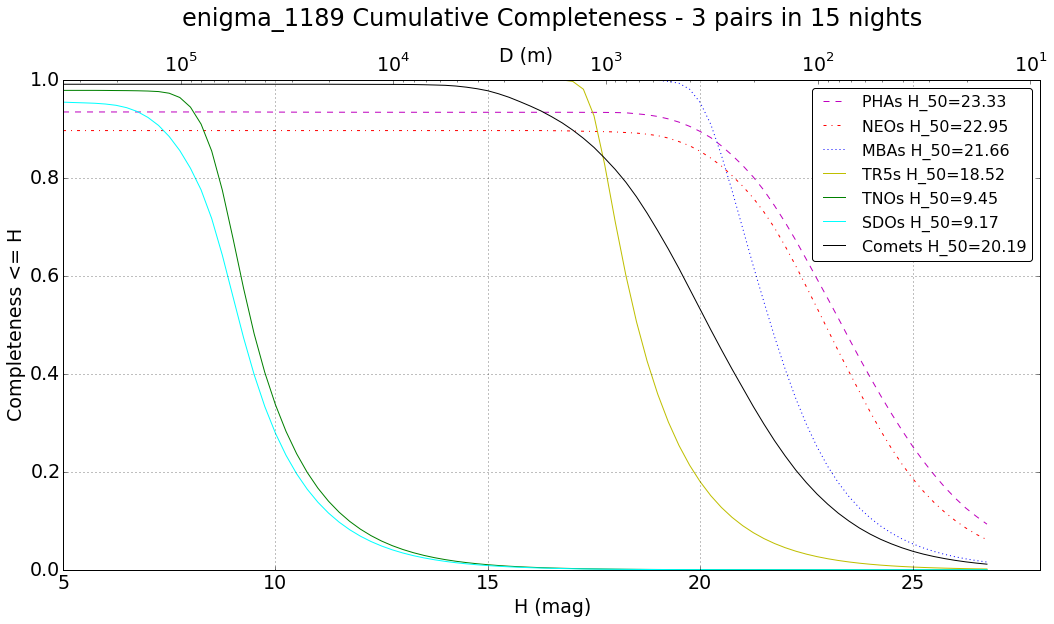

In [117]:
# Will use a mock metricBundle to generate plots. 
# The completeness values (what we typically want to plot here) are a summary value, not an actual metric value.
# So this little bit of fiddling lets us use the plotHandler as we would normally (with a metricBundle), but with 
# the actual values we want to plot. 

# Cumulative completeness, as function of 
compbundles = []
yr = max(nyears)
h50 = {}
for obj in objtypes:
    mos = moslicers[obj]
    completeness = allBundles[obj]['Discovery'][yr].summaryValues['CumulativeCompleteness'][0]
    f = interp1d(completeness, mos.Hrange)
    h50[obj] = f(0.5)
    #print obj, Hidx, cval, completeness, mos.Hrange
    plotDict = {'albedo':albedo, 'label':'%s H_50=%0.2f' 
                %(plotdicts[obj]['label'], h50[obj]), 
                'color':plotdicts[obj]['color'], 'linestyle':plotdicts[obj]['linestyle'],
                'title':'%s Cumulative Completeness - 3 pairs in 15 nights' %(runName), 
                'ylabel':'Completeness <= H', 'yMin':0, 'yMax':1}
    mb = makeCompletenessBundle(mos, completeness, plotDict)
    compbundles.append(mb)
ph.setMetricBundles(compbundles)
ph.plot(plotFunc=plots.MetricVsH(), plotDicts={'xMin':5, 'xMax':28, 'legendloc':'upper right'})
plt.savefig(os.path.join(outDir, 'CumulativeCompleteness_standard.pdf'), format='pdf')

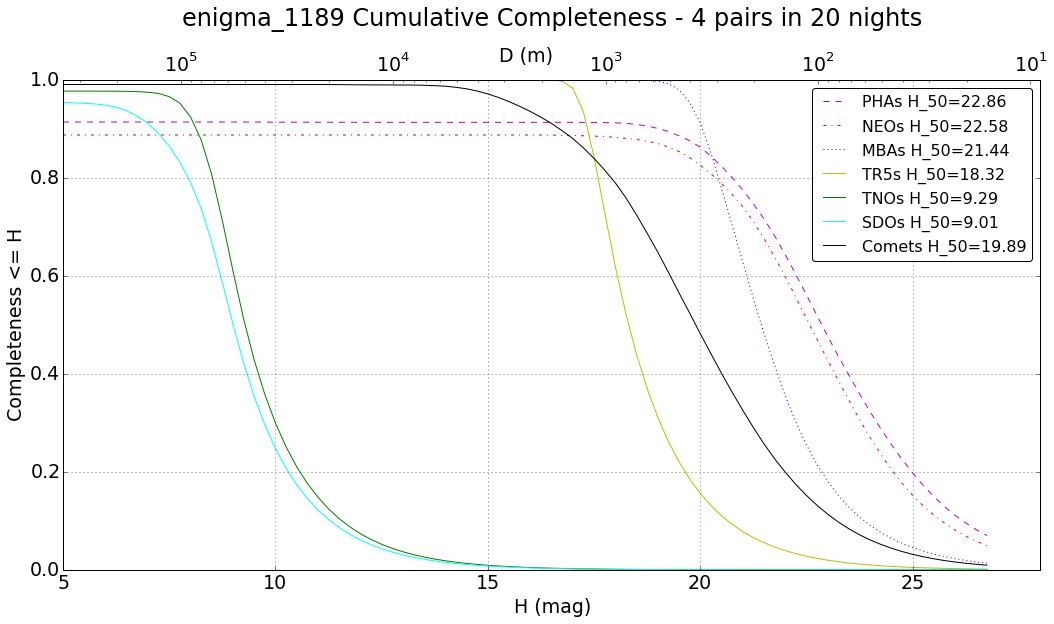

In [118]:
# Cumulative completeness, as function of 
compbundles = []
yr = max(nyears)
h50 = {}
for obj in objtypes:
    mos = moslicers[obj]
    completeness = allBundles[obj]['Extrapair'][yr].summaryValues['CumulativeCompleteness'][0]
    f = interp1d(completeness, mos.Hrange)
    h50[obj] = f(0.5)
    #print obj, Hidx, cval, completeness, mos.Hrange
    plotDict = {'albedo':albedo, 'label':'%s H_50=%0.2f' 
                %(plotdicts[obj]['label'], h50[obj]), 
                'color':plotdicts[obj]['color'], 'linestyle':plotdicts[obj]['linestyle'],
                'title':'%s Cumulative Completeness - 4 pairs in 20 nights' %(runName), 
                'ylabel':'Completeness <= H', 'yMin':0, 'yMax':1}
    mb = makeCompletenessBundle(mos, completeness, plotDict)
    compbundles.append(mb)
ph.setMetricBundles(compbundles)
ph.plot(plotFunc=plots.MetricVsH(), plotDicts={'xMin':5, 'xMax':28, 'legendloc':'upper right'})
plt.savefig(os.path.join(outDir, 'CumulativeCompleteness_four.pdf'), format='pdf')

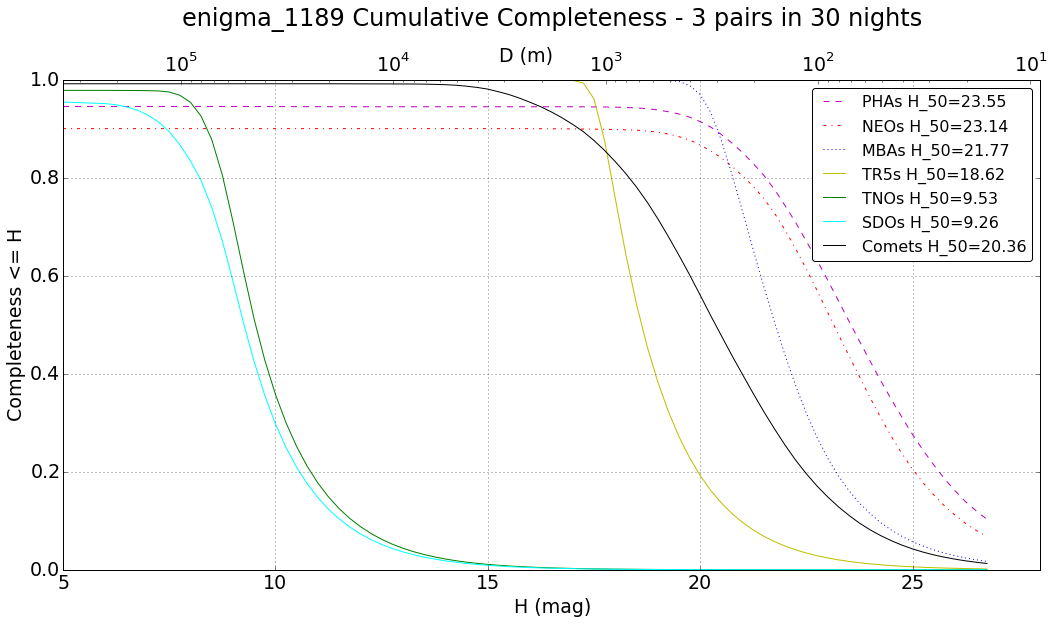

In [137]:
# Cumulative completeness, as function of H 
compbundles = []
h50 = {}
for obj in objtypes:
    mos = moslicers[obj]
    completeness = allBundles[obj]['Longdisc'][yr].summaryValues['CumulativeCompleteness'][0]
    f = interp1d(completeness, mos.Hrange)
    h50[obj] = f(0.5)
    #print obj, Hidx, cval, completeness, mos.Hrange
    plotDict = {'albedo':albedo, 'label':'%s H_50=%0.2f' 
                %(plotdicts[obj]['label'], h50[obj]), 
                'color':plotdicts[obj]['color'], 'linestyle':plotdicts[obj]['linestyle'],
                'title':'%s Cumulative Completeness - 3 pairs in 30 nights' %(runName), 
                'ylabel':'Completeness <= H', 'yMin':0, 'yMax':1}
    mb = makeCompletenessBundle(mos, completeness, plotDict)
    compbundles.append(mb)
ph.setMetricBundles(compbundles)
ph.plot(plotFunc=plots.MetricVsH(), plotDicts={'xMin':5, 'xMax':28, 'legendloc':'upper right'})
plt.savefig(os.path.join(outDir, 'CumulativeCompleteness_long.pdf'), format='pdf')

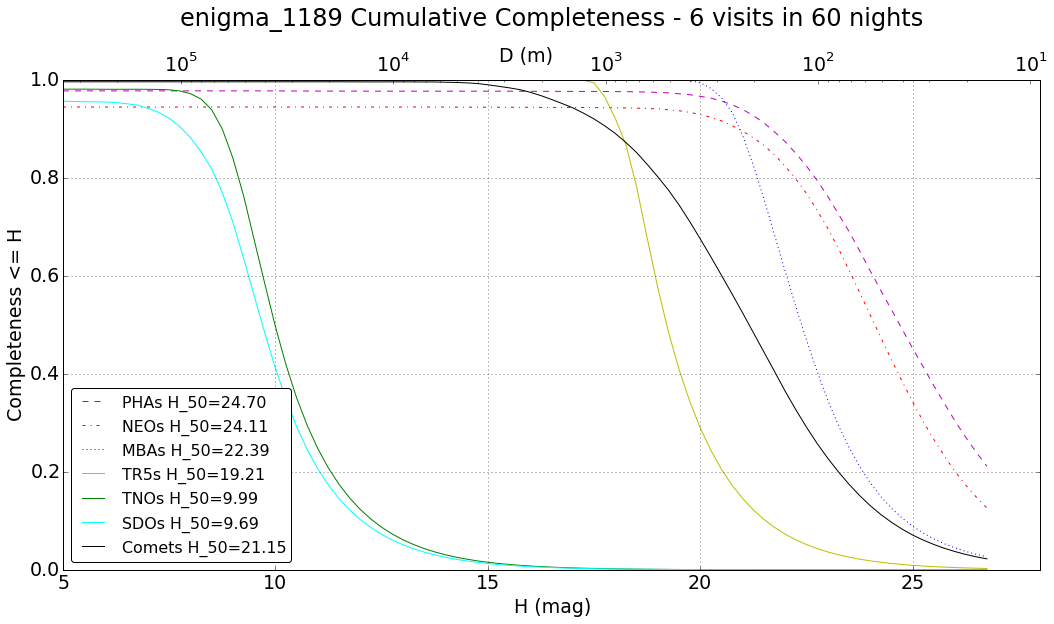

In [136]:
# Cumulative completeness, as function of H 
compbundles = []
h50 = {}
for obj in objtypes:
    mos = moslicers[obj]
    completeness = allBundles[obj]['Magic'].summaryValues['CumulativeCompleteness'][0]
    f = interp1d(completeness, mos.Hrange)
    h50[obj] = f(0.5)
    #print obj, Hidx, cval, completeness, mos.Hrange
    plotDict = {'albedo':albedo, 'label':'%s H_50=%0.2f' 
                %(plotdicts[obj]['label'], h50[obj]), 
                'color':plotdicts[obj]['color'], 'linestyle':plotdicts[obj]['linestyle'],
                'title':'%s Cumulative Completeness - 6 visits in 60 nights' %(runName), 
                'ylabel':'Completeness <= H', 'yMin':0, 'yMax':1}
    mb = makeCompletenessBundle(mos, completeness, plotDict)
    compbundles.append(mb)
ph.setMetricBundles(compbundles)
ph.plot(plotFunc=plots.MetricVsH(), plotDicts={'xMin':5, 'xMax':28, 'legendloc':'lower left'})
plt.savefig(os.path.join(outDir, 'CumulativeCompleteness_magic.pdf'), format='pdf')

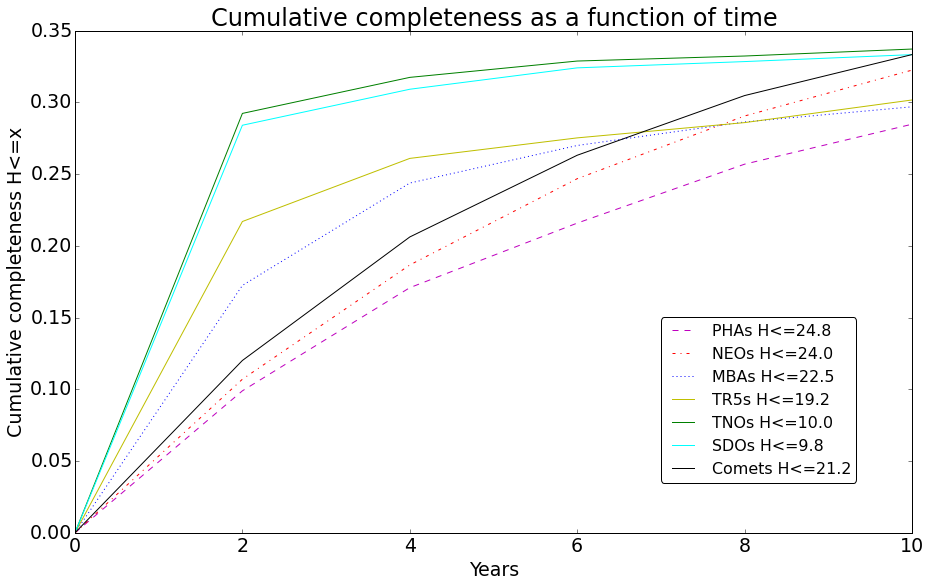

In [120]:
# Plot the cumulative completeness H<=Hval as a function of time.
for obj in objtypes:
    cvals = np.zeros(len(nyears)+1, float)
    cvals[0] = 0
    years = np.concatenate([np.array([0]), nyears])
    for i, yr in enumerate(nyears):
        mos = moslicers[obj]
        Hidx = np.abs(h50[obj] - mos.Hrange).argmin()
        Hmark = mos.Hrange[Hidx]
        completeness = allBundles[obj]['Discovery'][yr].summaryValues['CumulativeCompleteness'][0]
        cvals[i+1] = completeness[Hidx]
    plt.plot(years, cvals, color=plotdicts[obj]['color'], linestyle=plotdicts[obj]['linestyle'],
             label=plotdicts[obj]['label'] + ' H<=%.1f' %(Hmark)) 
plt.xlabel('Years')
plt.ylabel('Cumulative completeness H<=x')
plt.legend(loc=(0.7, 0.1), fancybox=True, fontsize='smaller')
plt.title('Cumulative completeness as a function of time')
plt.savefig(os.path.join(outDir, 'completeness_time.pdf'), format='pdf', dpi=600)

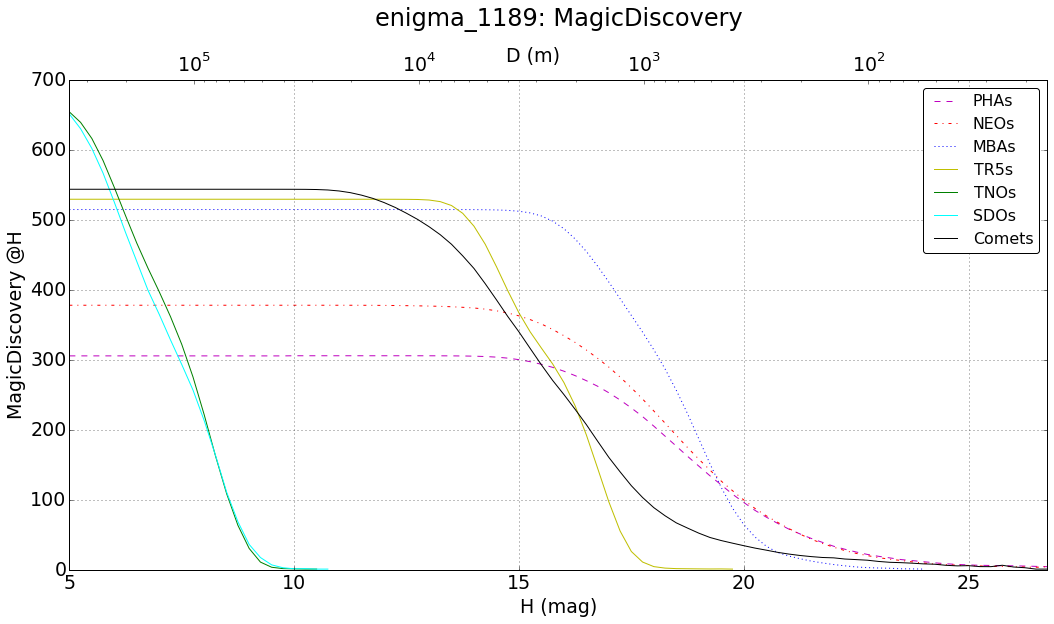

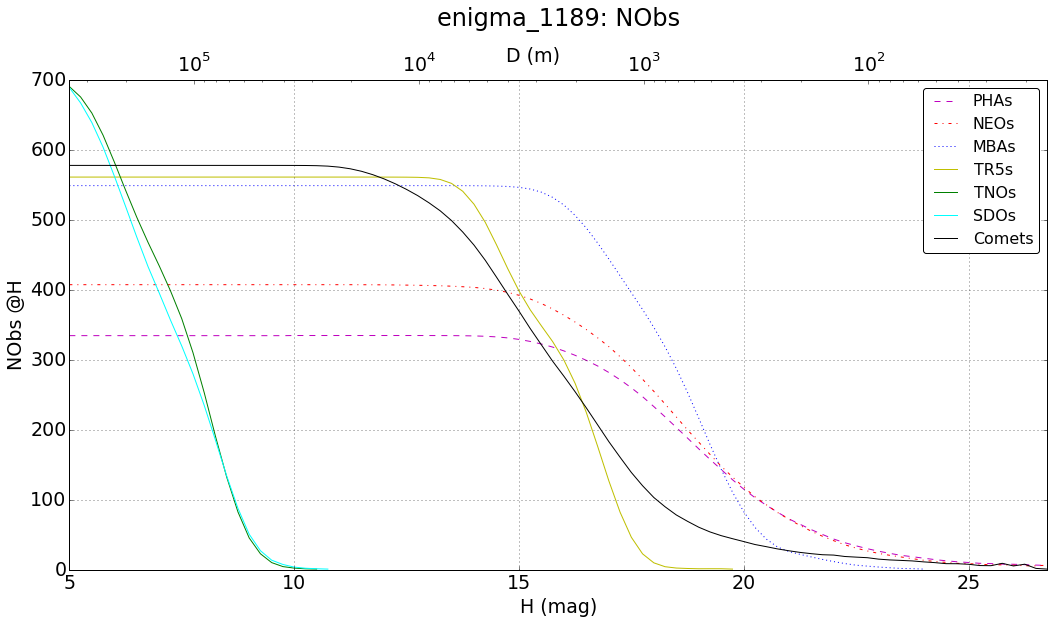

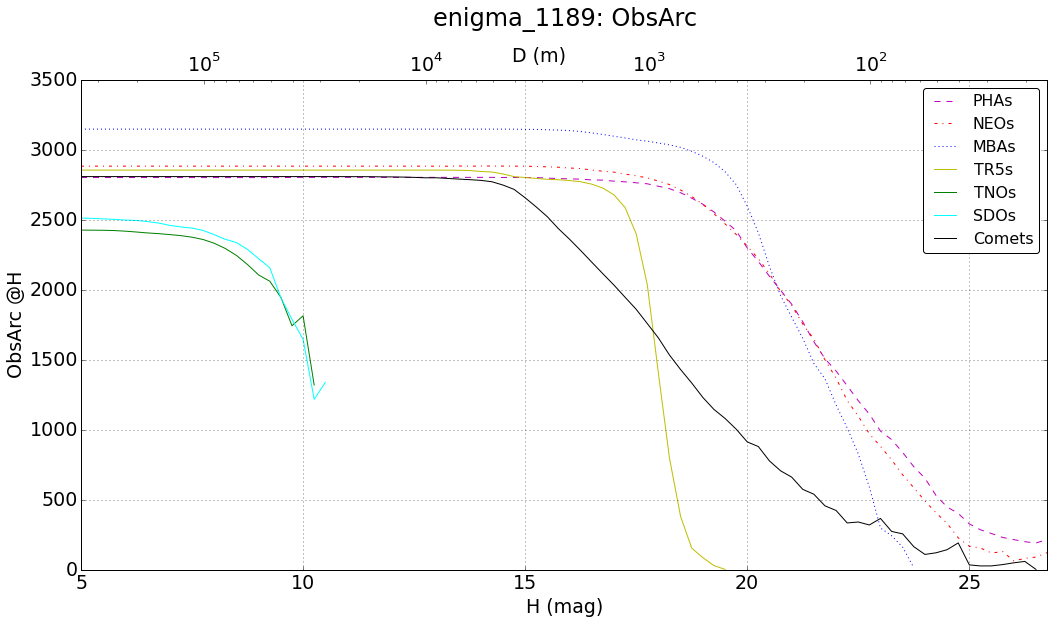

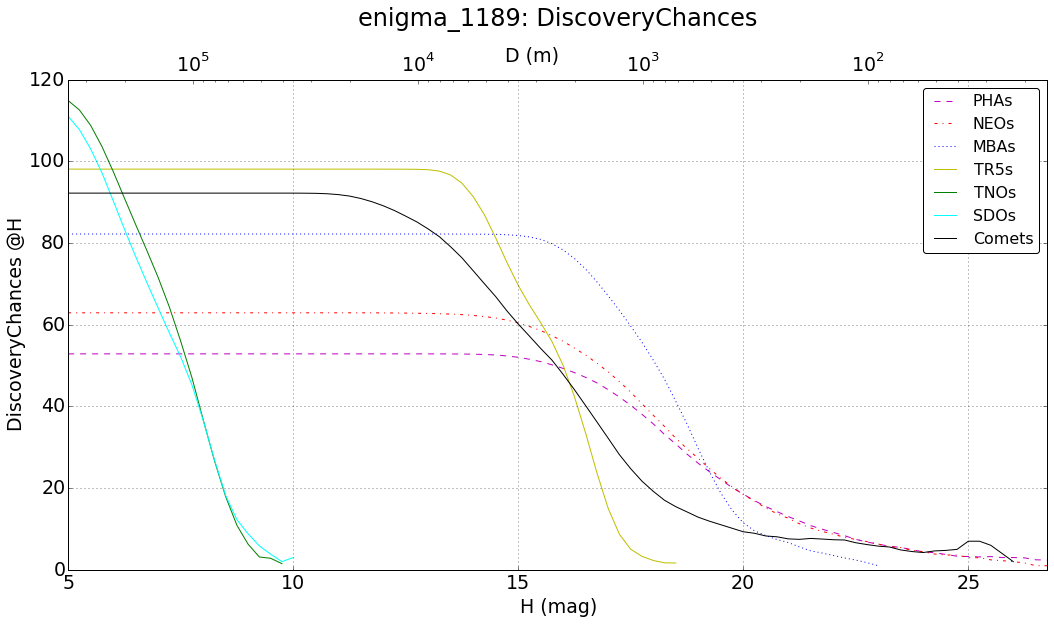

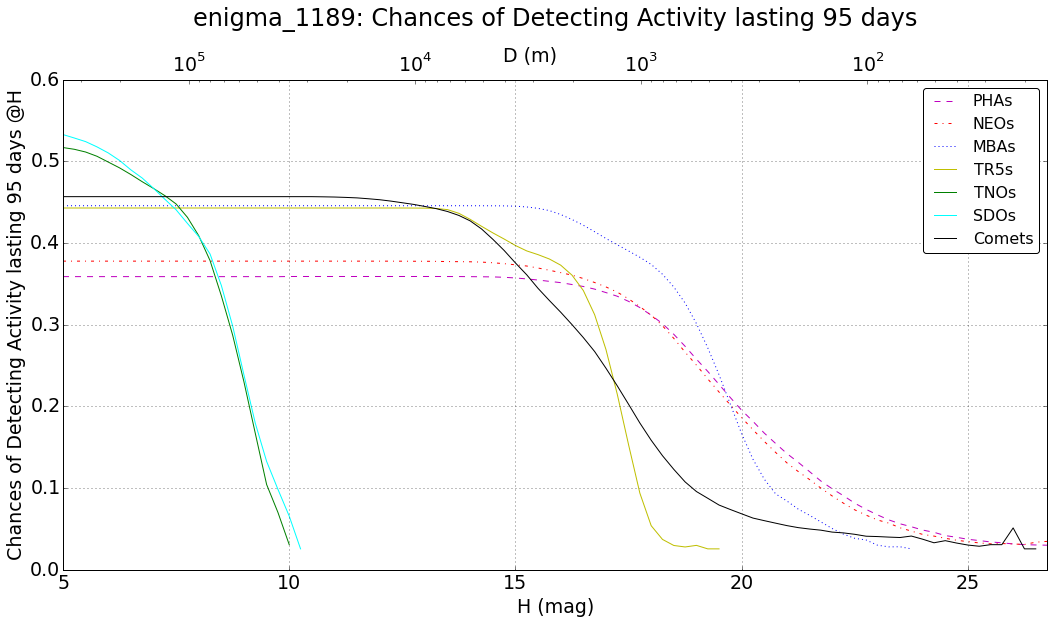

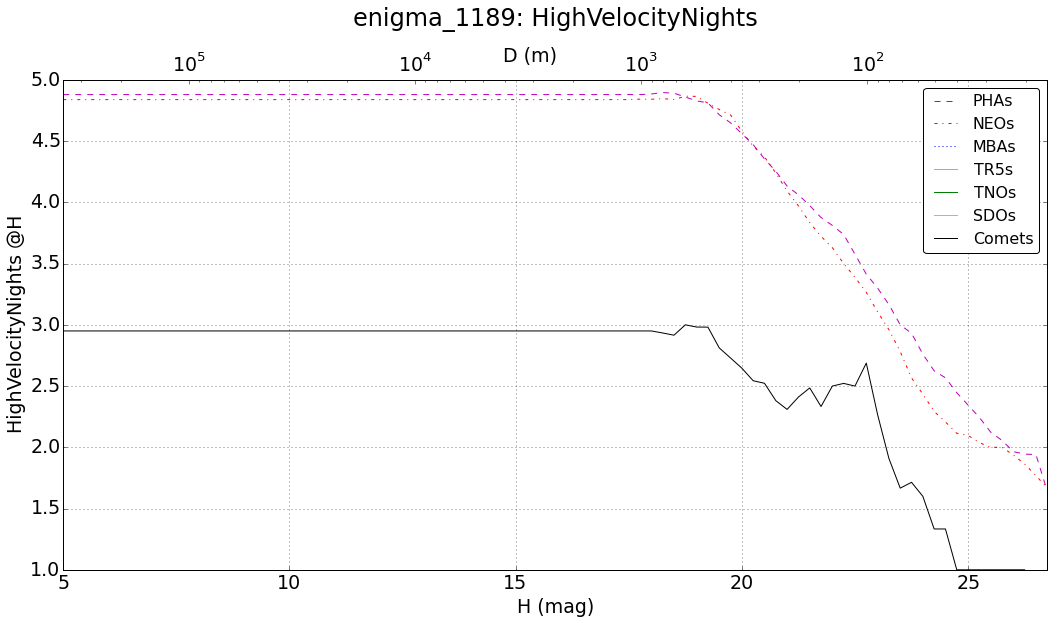

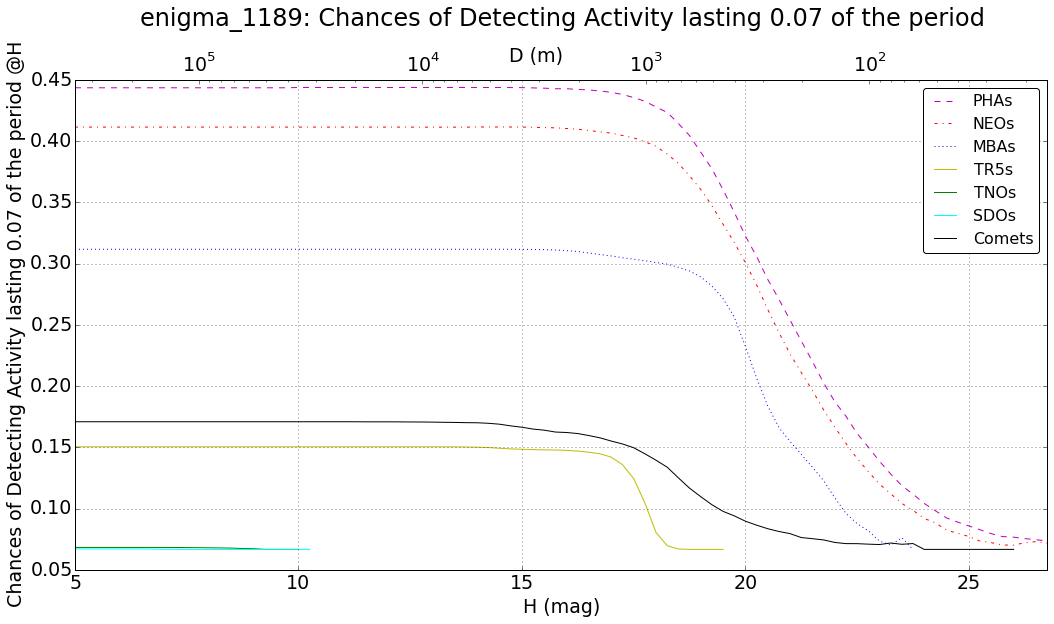

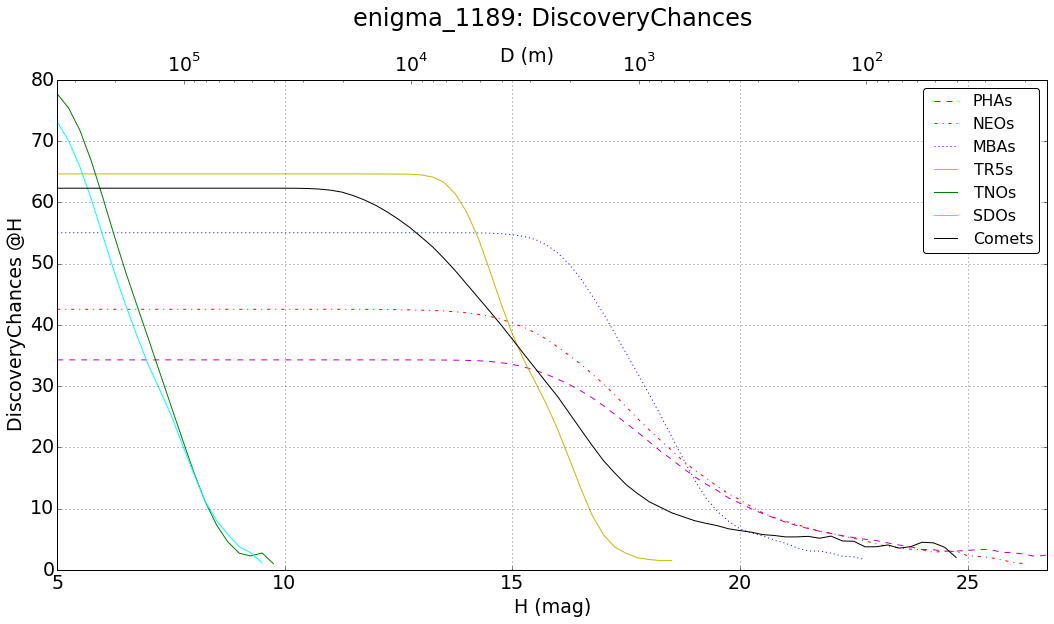

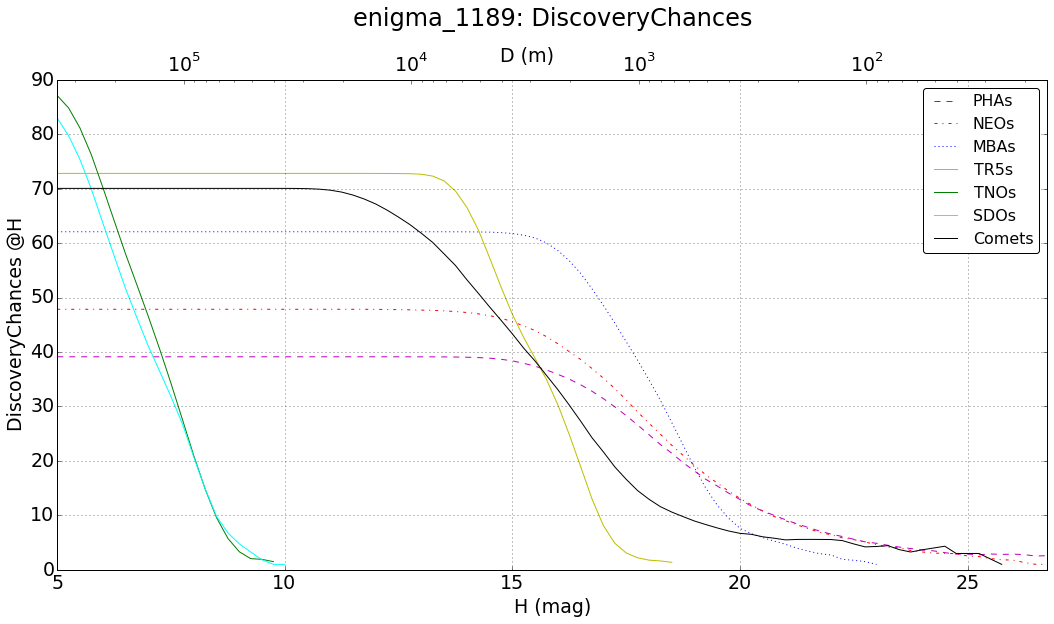

In [121]:
# PLOT the mean? median? values of each of these metrics as function of H.
for mplot in allBundles['neos'].keys():
    plotFunc = plots.MetricVsH()
    bundles = []
    pds = []
    for obj in objtypes:
        b = allBundles[obj][mplot]
        if isinstance(b, dict):
            k = allBundles[obj][mplot].keys()[-1]
            b = b[k]
        bundles.append(b)
        pds.append(plotdicts[obj])
    ph.setMetricBundles(bundles)
    ph.setPlotDicts(pds)
    ylabel = '%s %s' %(bundles[0].metric.name, bundles[0].plotDict['units'])
    title = '%s: %s' %(runName, mplot)
    ph.plot(plotFunc=plotFunc, plotDicts={'npReduce':np.mean, 'ylabel':ylabel, 'albedo':albedo,
                                         'xMin':Hrange[0], 'xMax':Hrange[-1]})

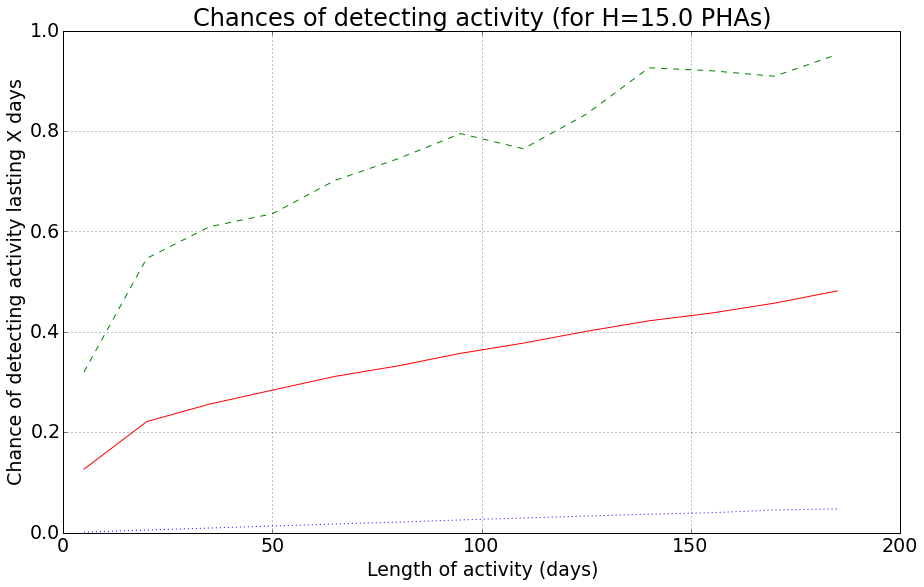

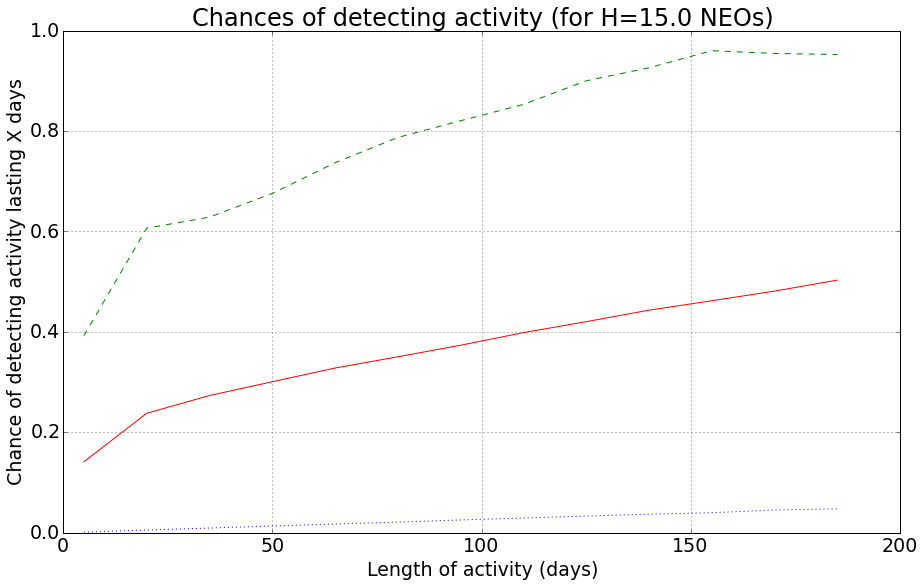

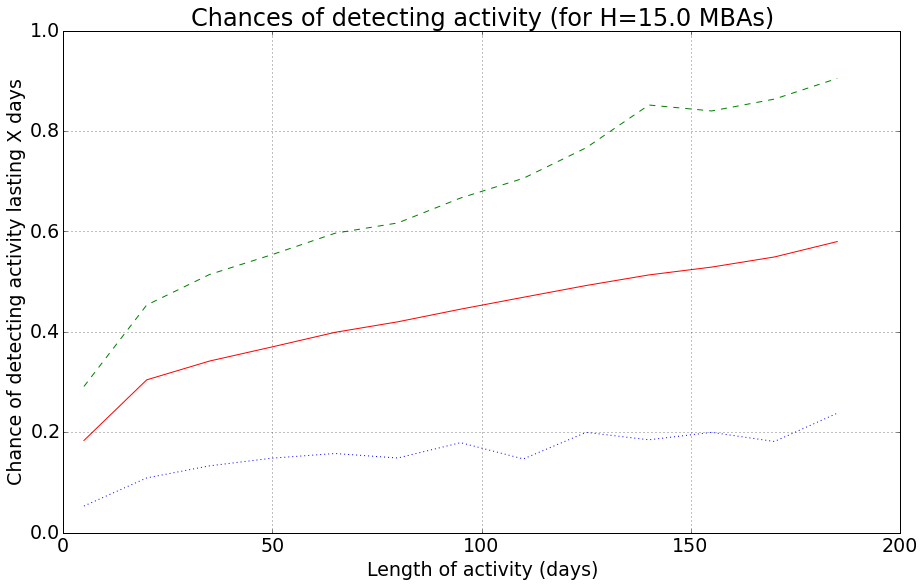

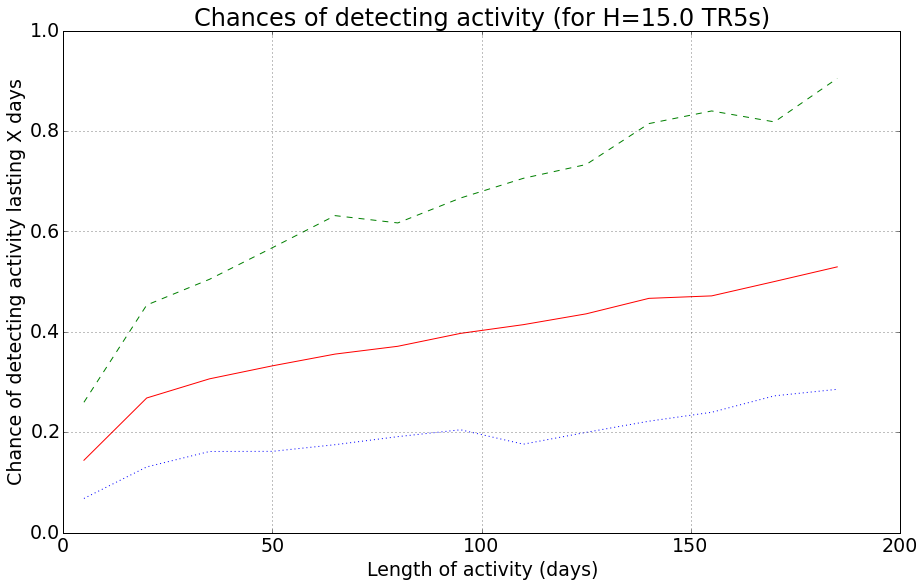

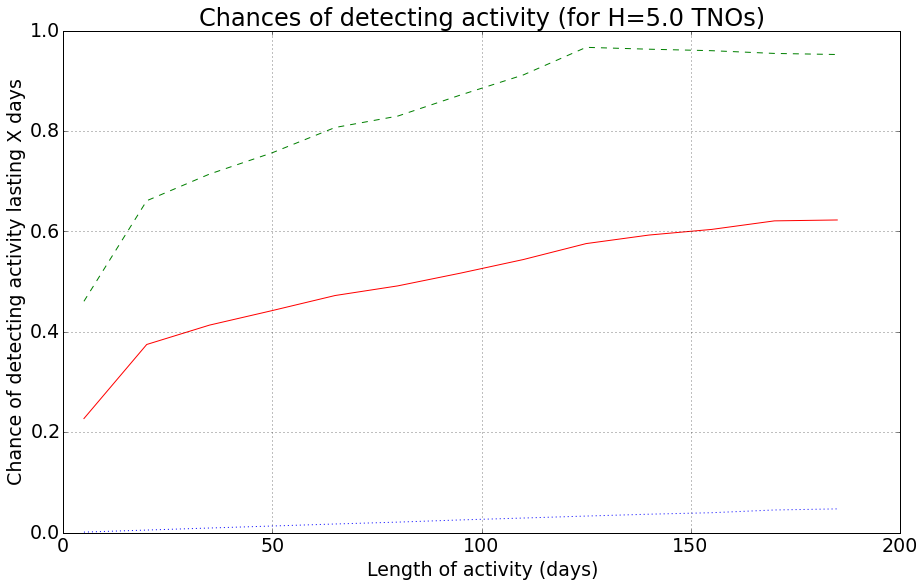

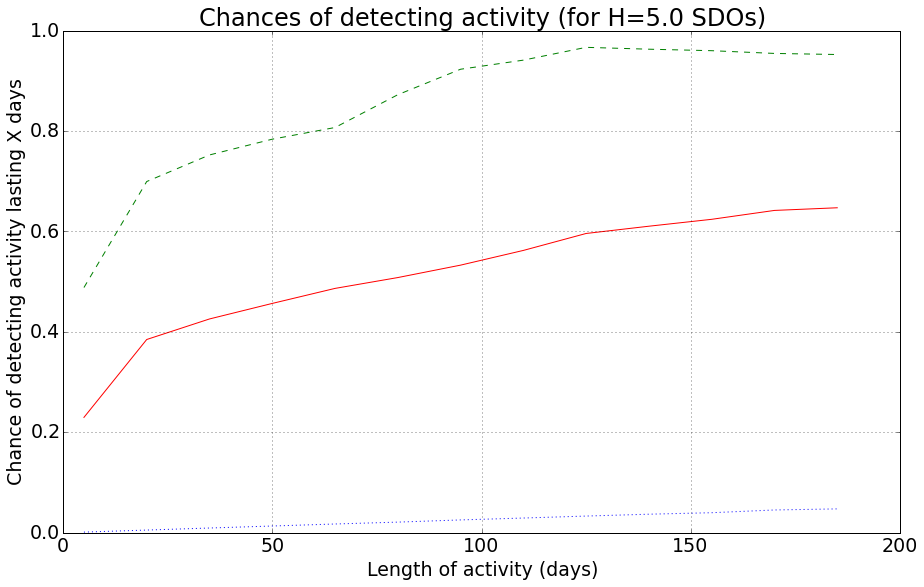

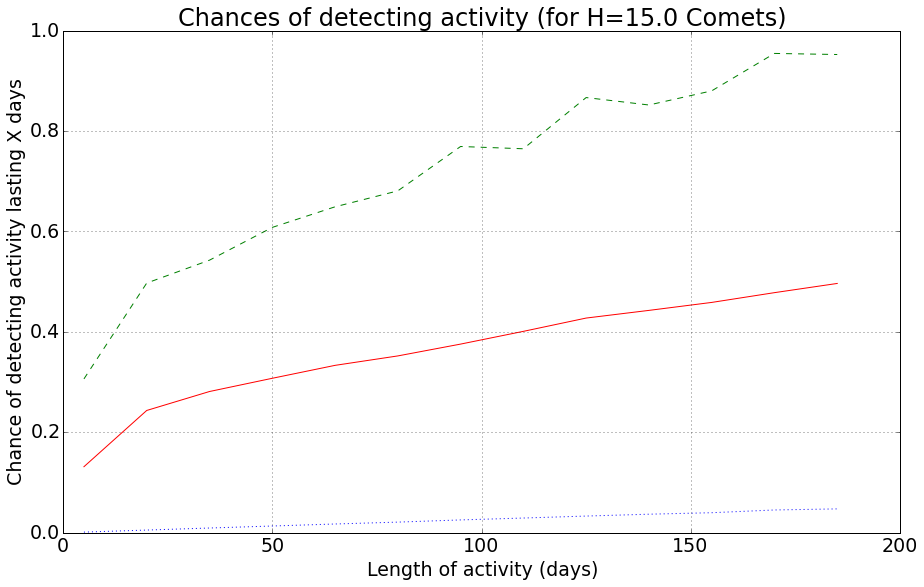

In [122]:
# Generate the chance of detecting activity for various objects over all windows. 
# Plot the min/mean/max of the fraction of activity detection opportunities

for obj in objtypes:
    meanFraction = np.zeros(len(windows), float)
    minFraction = np.zeros(len(windows), float)
    maxFraction = np.zeros(len(windows), float)

    # Just do this for the bright objects. 
    #  It will be similar down to the point where completeness falls off.
    #Hmark = h50[obj]
    if obj in ['sdos', 'tnos']:
        Hmark = 5
    else:
        Hmark = 15
    Hidx = np.where(moslicers['mbas'].Hrange  == Hmark)[0]
    #Hidx = 0
    #Hmark = moslicers['mbas'].Hrange[Hidx]
    for i, w in enumerate(windows):
        b = allBundles[obj]['ActivityTime'][w]
        meanFraction[i] = np.mean(b.metricValues.swapaxes(0, 1)[Hidx])
        minFraction[i] = np.min(b.metricValues.swapaxes(0, 1)[Hidx])
        maxFraction[i] = np.max(b.metricValues.swapaxes(0, 1)[Hidx])
    
    plt.figure()
    plt.plot(windows, meanFraction, 'r', label='Mean')
    plt.plot(windows, minFraction, 'b:', label='Min')
    plt.plot(windows, maxFraction, 'g--', label='Max')
    plt.xlabel('Length of activity (days)')
    plt.ylabel('Chance of detecting activity lasting X days')
    plt.title('Chances of detecting activity (for H=%.1f %s)' %(Hmark, plotdicts[obj]['label']))
    plt.grid()
    plt.savefig(os.path.join(outDir, '%s_activityTime.pdf' %(obj)), format='pdf', dpi=600) 

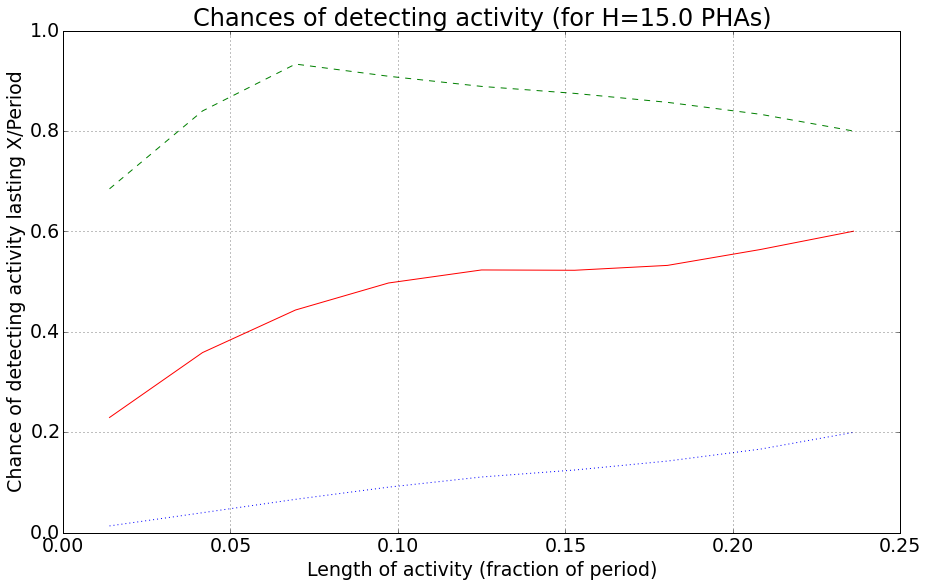

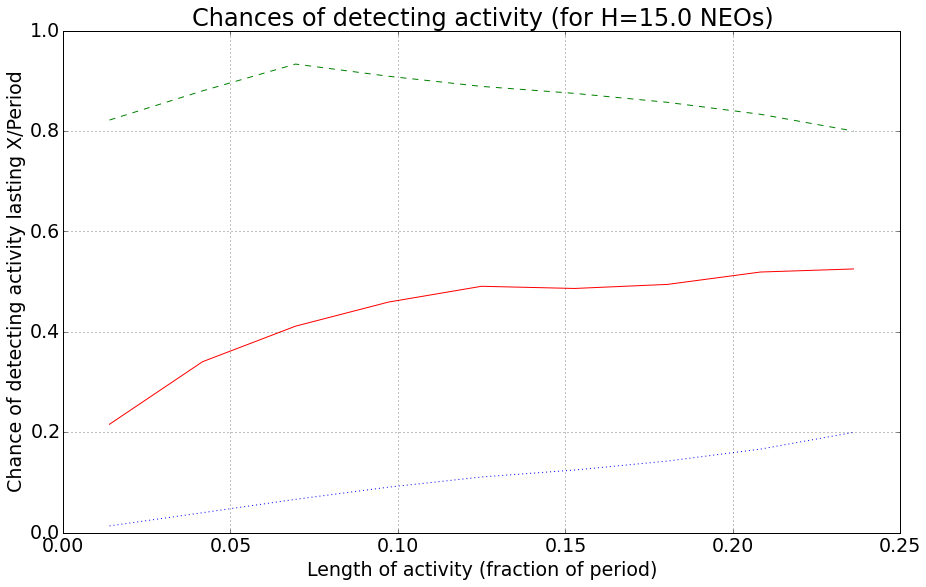

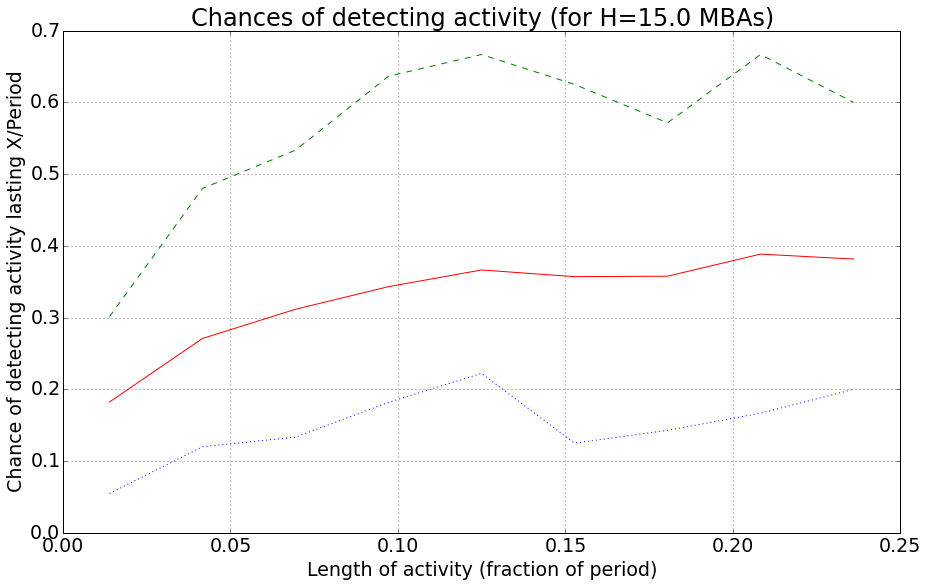

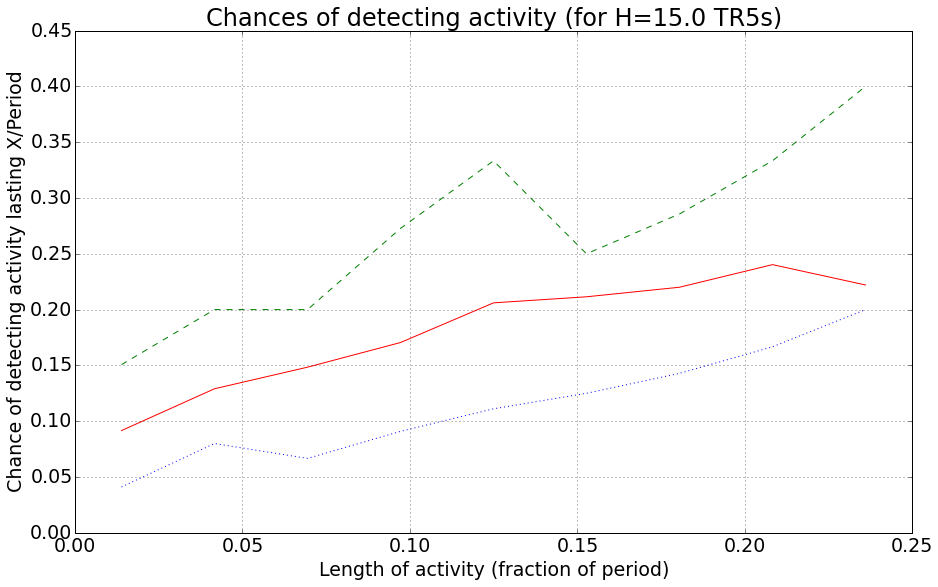

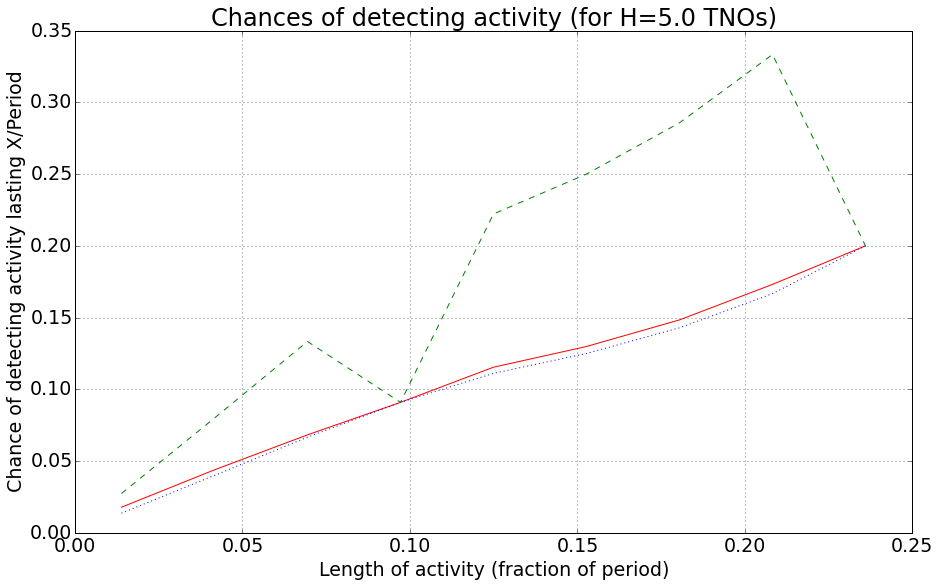

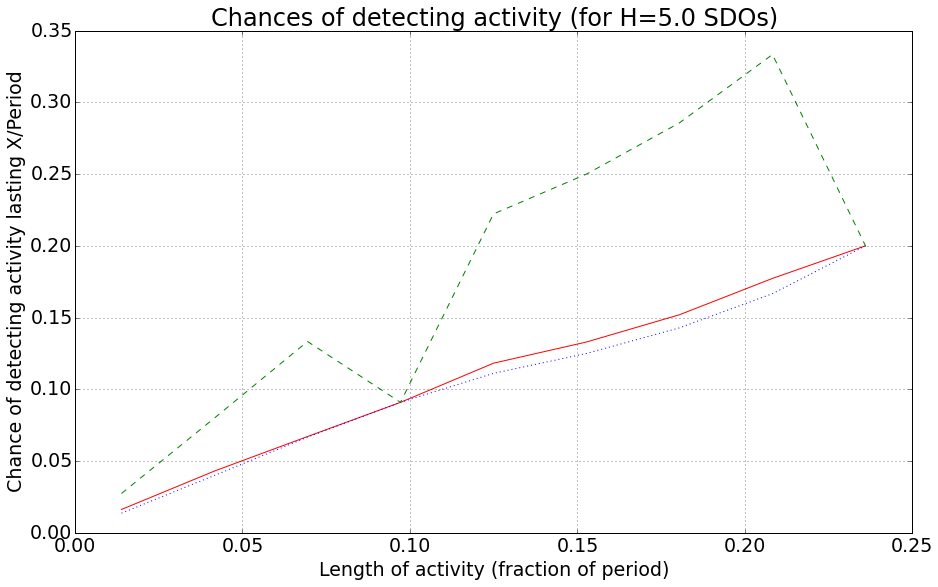

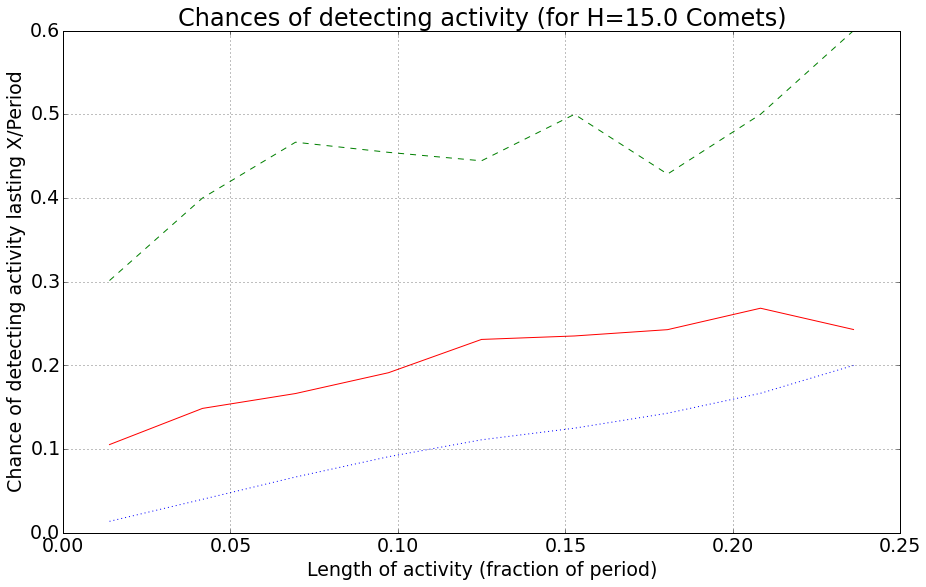

In [123]:
# Generate the chance of detecting activity for various objects over all bins (in orbit period). 
# Plot the min/mean/max of the fraction of activity detection opportunities

for obj in objtypes:
    meanFraction = np.zeros(len(bins), float)
    minFraction = np.zeros(len(bins), float)
    maxFraction = np.zeros(len(bins), float)

    # Maybe just do this for the brightest objects. 
    #  It will be similar down to the point where completeness falls off.
    #Hmark = h50[obj]
    if obj in ['sdos', 'tnos']:
        Hmark = 5
    else:
        Hmark = 15
    Hidx = np.where(moslicers['mbas'].Hrange  == Hmark)[0]
    #Hidx = 0
    #Hmark = moslicers['mbas'].Hrange[Hidx]
    for i, w in enumerate(bins):
        b = allBundles[obj]['ActivityPeriod'][w]
        meanFraction[i] = np.mean(b.metricValues.swapaxes(0, 1)[Hidx])
        minFraction[i] = np.min(b.metricValues.swapaxes(0, 1)[Hidx])
        maxFraction[i] = np.max(b.metricValues.swapaxes(0, 1)[Hidx])
    
    plt.figure()
    plt.plot(bins/360., meanFraction, 'r', label='Mean')
    plt.plot(bins/360., minFraction, 'b:', label='Min')
    plt.plot(bins/360., maxFraction, 'g--', label='Max')
    plt.xlabel('Length of activity (fraction of period)')
    plt.ylabel('Chance of detecting activity lasting X/Period')
    plt.title('Chances of detecting activity (for H=%.1f %s)' %(Hmark, plotdicts[obj]['label']))
    plt.grid()
    plt.savefig(os.path.join(outDir, '%s_activityPeriod.pdf' %(obj)), format='pdf', dpi=600) 

In [50]:
# Turn completeness into number of objects for MBAs
obj = 'mbas'
mos = moslicers[obj]
Hrange = mos.Hrange
Hbinsize = np.unique(np.diff(Hrange))[0]
Hextension = np.arange(7, Hrange.min()-Hbinsize/2.0, Hbinsize)
bigHrange = np.concatenate([Hextension, Hrange])

yr=max(nyears)
completeness = allBundles[obj]['Discovery'][yr].summaryValues['Completeness'][0]
bigcompleteness = np.concatenate([np.ones(len(Hextension)), completeness])

diffHrange = np.concatenate([(bigHrange - Hbinsize/2.0), np.array([Hrange.max() + Hbinsize/2.0])])
x = diffHrange - 15.7
ncum = 267000 * (np.power(10, 0.43*x))/(np.power(10, 0.18*x) + np.power(10, -0.18*x))
ndiff = ncum[1:] - ncum[:-1]
nfound = ndiff * bigcompleteness

ncum2 = np.zeros(len(diffHrange))
C = np.log10(50000) # @ H=14.5
condition = np.where(diffHrange>14.5)
ncum2[condition] = np.power(10, C + 0.38 * (diffHrange[condition] - 14.5) )
condition = np.where(diffHrange<=14.5)
ncum2[condition] = np.power(10, C + 0.51 * (diffHrange[condition] - 14.5))
ndiff2 = ncum2[1:] - ncum2[:-1]
nfound2 = ndiff2 * bigcompleteness
#for H, N, Nf in zip(Hrange, ncum, nfound):
#    print H, N, Nf
#fig = plt.figure()
#plt.semilogy(bigHrange, nfound)
#plt.semilogy(bigHrange, nfound2, 'r-')
#ax = fig.gca()
#plt.xlim(3, 27)

(3, 27)

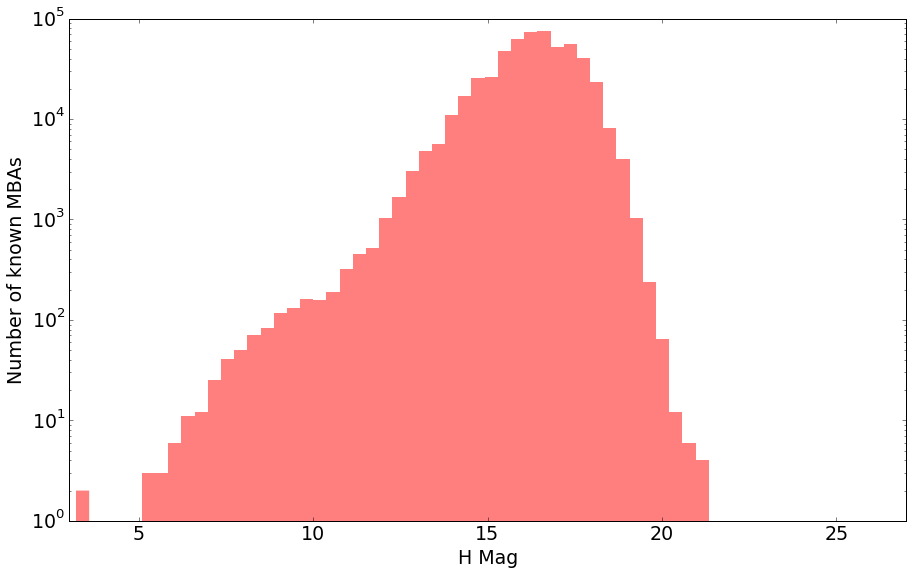

In [124]:
import pandas as pd
ast = pd.read_table('asteroidDb/mpc_mba.dat', delim_whitespace=True, error_bad_lines=False, low_memory=False)
ast['H'].plot(kind='hist', bins=50, logy=True, alpha=0.5, color='r', edgecolor='none', label='Known MBAs')
plt.xlabel('H Mag')
plt.ylabel('Number of known MBAs')
plt.xlim(3, 27)

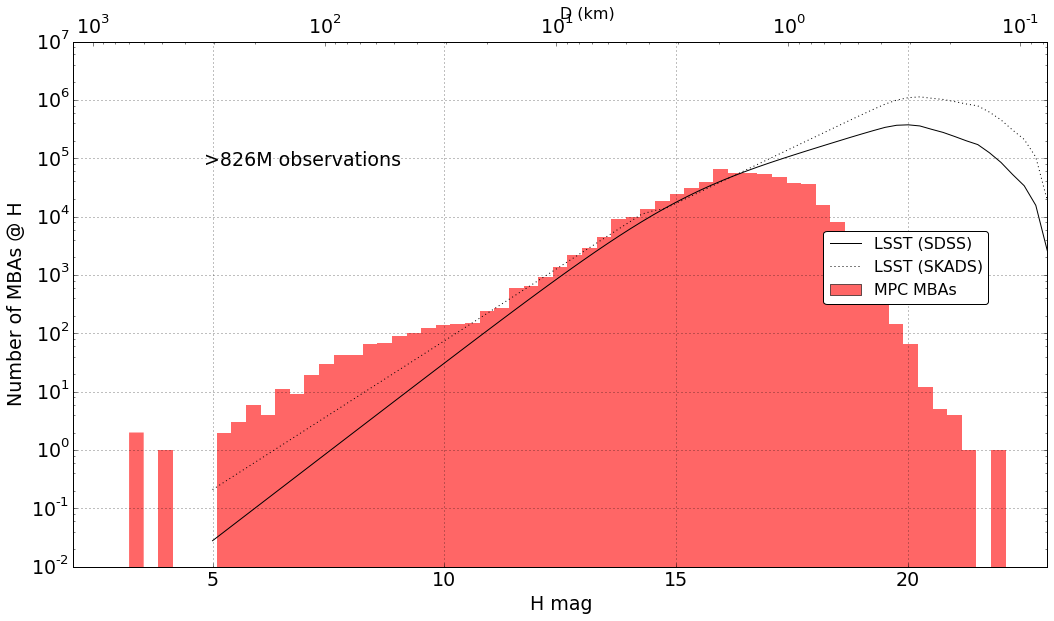

In [125]:
# Differential count of number of MBAs
plt.plot(bigHrange[:-9], nfound[:-9],  color='k', label='LSST (SDSS)')
plt.plot(bigHrange[:-9], nfound2[:-9], color='k', linestyle=':', label='LSST (SKADS)')
plt.hist(ast['H'], bins=60, alpha=0.6, color='r', edgecolor='none', label='MPC MBAs')
leg = plt.legend(loc=(0.77, 0.5), fancybox=True, numpoints=1, fontsize='smaller')
leg.get_frame().set_zorder(0)
leg.get_frame().set_facecolor('white')
plt.ylabel("Number of MBAs @ H")
plt.xlabel("H mag")
plt.xlim(2, 23.)

mag_sun = -27.1 
km_per_au = 1.496e8
albedo = 0.14
ax = plt.axes()
ax2 = ax.twiny()
hmin, hmax = ax.get_xlim()
dmax = 2.0 * np.sqrt(10**((mag_sun - hmin - 2.5*np.log10(albedo))/2.5))
dmin = 2.0 * np.sqrt(10**((mag_sun - hmax - 2.5*np.log10(albedo))/2.5))
dmax = dmax * km_per_au
dmin = dmin * km_per_au
ax2.set_xlim(dmax, dmin)
ax2.set_xscale('log')
ax2.set_xlabel('D (km)', labelpad=-5, horizontalalignment='left', fontsize='smaller')
plt.sca(ax)
plt.grid(True)
plt.yscale('log', nonposy='clip')
plt.figtext(0.2, 0.72, '>826M observations')
plt.tight_layout()
plt.savefig(os.path.join(outDir, 'N_MBAs.pdf'),  format='pdf', dpi=600)

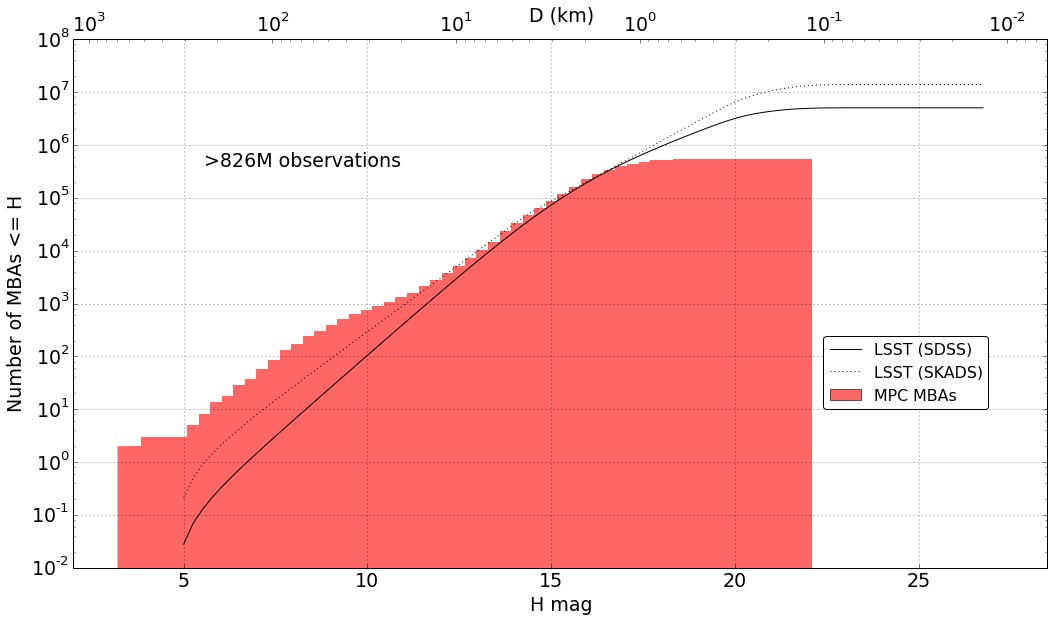

In [126]:
# cumulative number of objects (<=H)
plt.plot(bigHrange, nfound.cumsum(),  color='k', label='LSST (SDSS)')
plt.plot(bigHrange, nfound2.cumsum(), color='k', linestyle=':', label='LSST (SKADS)')
plt.hist(ast['H'], bins=60, alpha=0.6, color='r', edgecolor='none', label='MPC MBAs', cumulative=True)
leg = plt.legend(loc=(0.77, 0.3), fancybox=True, numpoints=1, fontsize='smaller')
leg.get_frame().set_zorder(0)
leg.get_frame().set_facecolor('white')
plt.ylabel("Number of MBAs <= H")
plt.xlabel("H mag")
plt.xlim(2, 28.5)

mag_sun = -27.1 
km_per_au = 1.496e8
albedo = 0.14
ax = plt.axes()
ax2 = ax.twiny()
hmin, hmax = ax.get_xlim()
dmax = 2.0 * np.sqrt(10**((mag_sun - hmin - 2.5*np.log10(albedo))/2.5))
dmin = 2.0 * np.sqrt(10**((mag_sun - hmax - 2.5*np.log10(albedo))/2.5))
dmax = dmax * km_per_au
dmin = dmin * km_per_au
ax2.set_xlim(dmax, dmin)
ax2.set_xscale('log')
ax2.set_xlabel('D (km)', labelpad=-10, horizontalalignment='center')
plt.sca(ax)
plt.grid(True)
plt.yscale('log', nonposy='clip')
plt.figtext(0.2, 0.72, '>826M observations')
plt.tight_layout()
plt.savefig(os.path.join(outDir, 'N_MBAs_cum.pdf'), format='pdf', dpi=600)

0 0.0 0.0
2 3117393.39598 0.616133809121
4 4257397.105 0.841448595685
6 4656291.17748 0.920287578481
8 4905734.03424 0.969588439159
10 5059604.50446 1.0


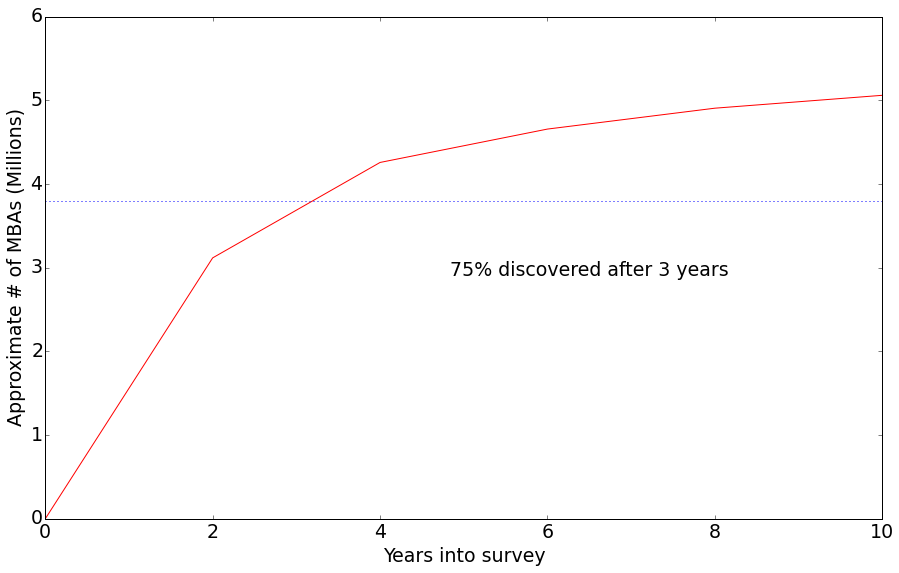

In [128]:
# Turn completeness into number of objects.
obj = 'mbas'
mos = moslicers[obj]
Hrange = mos.Hrange
Hbinsize = np.unique(np.diff(Hrange))[0]
Hextension = np.arange(7, Hrange.min()-Hbinsize/2.0, Hbinsize)
bigHrange = np.concatenate([Hextension, Hrange])

diffHrange = np.concatenate([(bigHrange - Hbinsize/2.0), np.array([Hrange.max() + Hbinsize/2.0])])
x = diffHrange - 15.7
ncum = 267000 * (np.power(10, 0.43*x))/(np.power(10, 0.18*x) + np.power(10, -0.18*x))
ndiff = ncum[1:] - ncum[:-1]
ncum2 = np.zeros(len(diffHrange))
C = np.log10(50000) # @ H=14.5
condition = np.where(diffHrange>14.5)
ncum2[condition] = np.power(10, C + 0.38 * (diffHrange[condition] - 14.5) )
condition = np.where(diffHrange<=14.5)
ncum2[condition] = np.power(10, C + 0.51 * (diffHrange[condition] - 14.5))
ndiff2 = ncum2[1:] - ncum2[:-1]

ncounts = np.zeros(len(years))
for i, yr in enumerate(years):
    if yr == 0:
        ncounts[i] = 0
        continue
    completeness = allBundles[obj]['Discovery'][yr].summaryValues['Completeness'][0]
    bigcompleteness = np.concatenate([np.ones(len(Hextension)), completeness])
    nfound = ndiff * bigcompleteness
    ncounts[i] = nfound.sum()
for y, c in zip(years, ncounts):
    print y, c, c/ncounts[-1]
plt.plot(years, ncounts/1000000., 'r')
plt.xlabel('Years into survey')
plt.ylabel('Approximate # of MBAs (Millions)')
#plt.axvline(3, color='b', linestyle=':')
plt.axhline(ncounts[-1]*.75/1000000.0, color='b', linestyle=':')
plt.figtext(0.5, 0.5, '75%s discovered after 3 years' %('%'))
plt.savefig(os.path.join(outDir, 'N_MBAPerYear.pdf'), format='pdf', dpi=600)

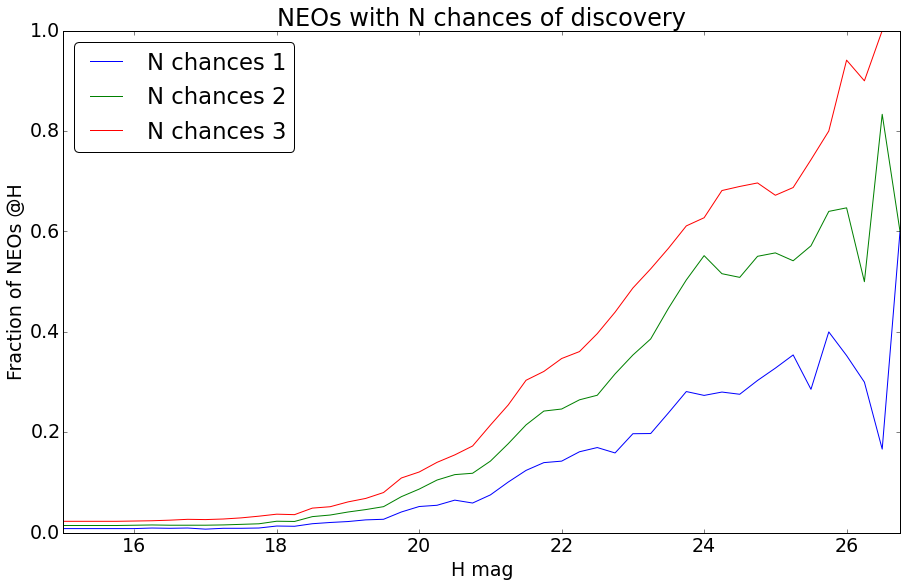

In [129]:
# Plot the fraction of objects with only X discovery chances, in year 10 of survey in standard discovery.
b = allBundles['neos']['Discovery'][10]
Hrange = mos.Hrange
nchances = np.arange(1, 4, 1)
mVals = b.metricValues.swapaxes(0, 1).filled(0)
for n in nchances:
    fraction = np.zeros(len(Hrange), float)
    for i, (H, mVal) in enumerate(zip(Hrange, mVals)):  
        match = np.where(mVal>0)
        n_available = float(len(match[0]))
        fraction[i] = len(np.where(mVal[match]<=n)[0]) / n_available
    plt.plot(Hrange, fraction, label='N chances %d' %(n))
plt.legend(loc='upper left', fancybox=True)
#plt.ylim(0, 5)
plt.xlim(15, Hrange.max())
plt.xlabel('H mag')
plt.ylabel('Fraction of NEOs @H')
plt.title('NEOs with N chances of discovery')
plt.savefig(os.path.join(outDir, '%s_FractionNDiscoveryChances.pdf' %(runName)), format='pdf')